In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 200
num_node = 14300
num_var = 4

n_epochs = 15000
batch_size = 10
LR =1e-4
Lv1_latent_dim = 128

alpha = 0

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[2,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[3,0:num_node,:]=data.values[0:num_node,:]
del(data)



# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 2000)
(14300, 2000)
(14300, 2000)
(14300, 2000)
(4, 14300, 2000)
2000


In [11]:
# validate
data_save.shape

(4, 14300, 2000)

In [12]:
data_save[0,:,0]

array([-6.89786095e-02, -1.12475000e-04, -5.79693520e-02, ...,
        9.36027045e-05,  9.64131082e-05,  1.26859516e-04])

In [13]:
x_axis = np.linspace(0,num_node,num_node)
x_axis2 = np.linspace(0, num_time, num_time)

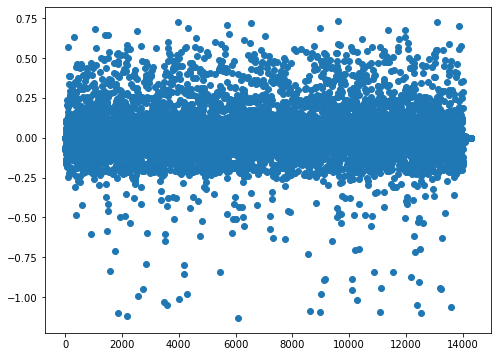

In [14]:
plt.scatter(x_axis, data[0,:,0])

In [15]:
data

array([[[-6.89786095e-02, -6.90686095e-02, -6.91686095e-02, ...,
          5.94513905e-02,  5.53013905e-02,  5.10313905e-02],
        [-1.12475000e-04, -1.12475000e-04, -1.12475000e-04, ...,
          1.17525000e-04,  1.17525000e-04,  1.17525000e-04],
        [-5.79693520e-02, -6.00293520e-02, -6.18193520e-02, ...,
         -2.53593520e-02, -1.98793520e-02, -1.32493520e-02],
        ...,
        [ 9.36027045e-05,  9.78147045e-05,  1.01694705e-04, ...,
         -3.08229295e-04, -2.99705295e-04, -3.16787295e-04],
        [ 9.64131082e-05,  1.00752108e-04,  1.04748108e-04, ...,
         -3.17483892e-04, -3.08703892e-04, -3.26297892e-04],
        [ 1.26859516e-04,  1.32568516e-04,  1.37827516e-04, ...,
         -4.17743484e-04, -4.06191484e-04, -4.29341484e-04]],

       [[ 1.14076923e-01,  1.08896723e-01,  1.04070523e-01, ...,
          1.46918123e-01,  1.55649123e-01,  1.64449123e-01],
        [ 4.07609774e-04,  4.17334774e-04,  4.25319774e-04, ...,
         -1.26194523e-03, -1.26030523e

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 200, 14300, 4)

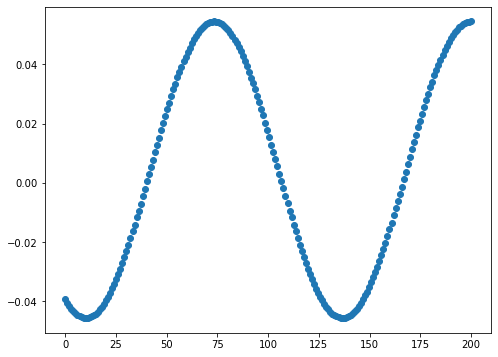

In [17]:
plt.scatter(x_axis2, FOM_data[0,:,0,3])

In [18]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

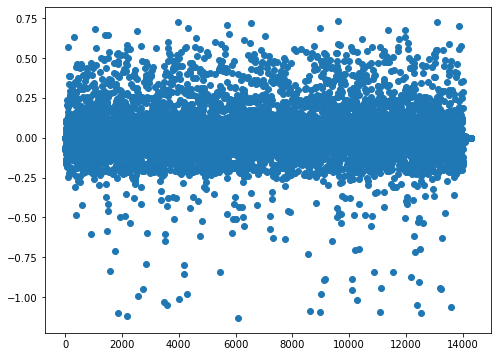

In [19]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [20]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0689786094999989
-0.053598609499999
-0.069068609499999
-0.0579693519999993


In [21]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [22]:
print(maximum)
print(minimum)
print(mean)
print(AT)

1.975119874
-2.98124239376
-1.687812283097838e-17
4.95636226776


In [23]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [24]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.39850191880599645
-0.6014980811940035


In [25]:
FOM_data.shape

(10, 200, 14300, 4)

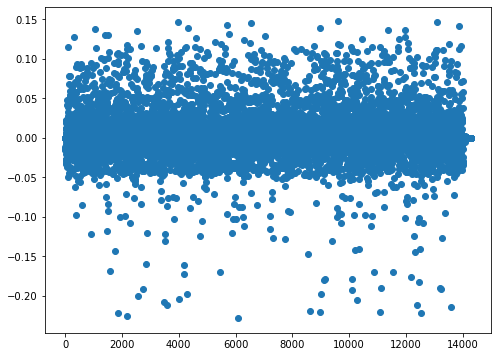

In [26]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

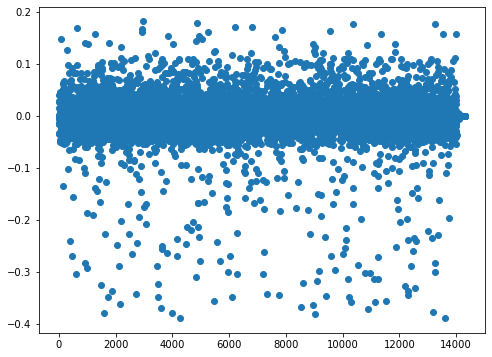

In [27]:
plt.scatter(x_axis, FOM_data[2,0,:,0])

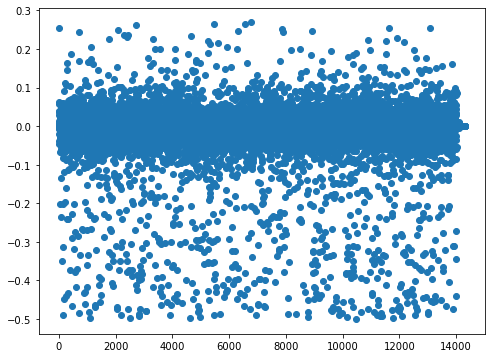

In [28]:
plt.scatter(x_axis, FOM_data[9,0,:,0])

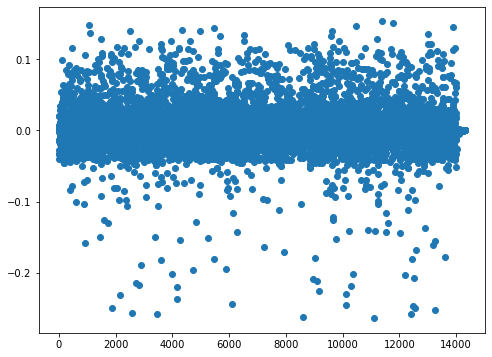

In [29]:
plt.scatter(x_axis, FOM_data[0,4,:,0])

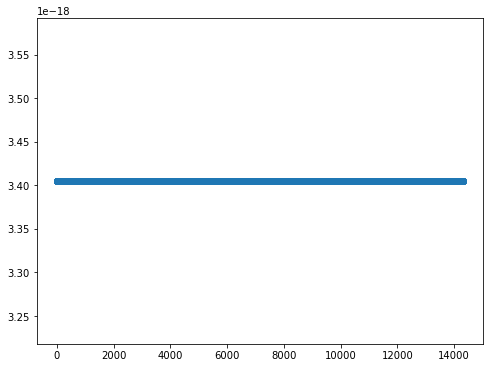

In [30]:
plt.scatter(x_axis, FOM_data[0,0,:,2])

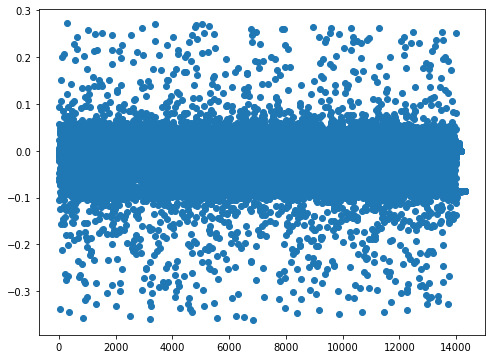

In [31]:
plt.scatter(x_axis, FOM_data[9,0,:,1])

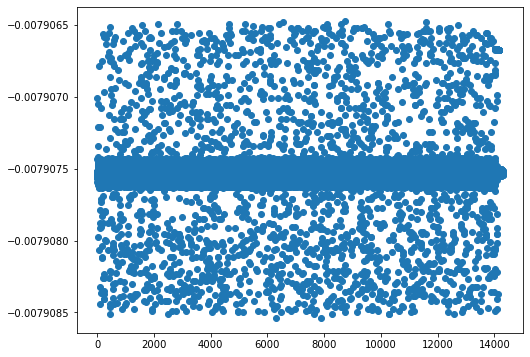

In [32]:
plt.scatter(x_axis, FOM_data[0,0,:,3])

# Level 1, SVAE (spatial VAE)

In [33]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(2000, 14300, 4)

In [34]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [35]:
Lv1_input_shape = Lv1_input.shape[1:]

In [36]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(2000, 14300, 4)
(14300, 4)


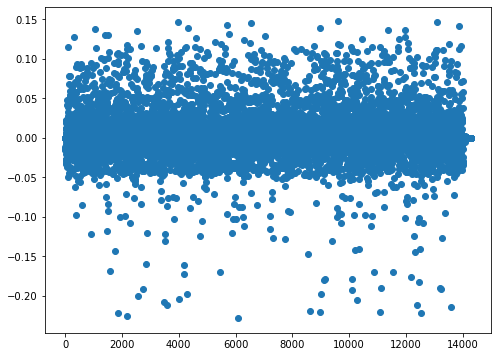

In [37]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

In [38]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 4)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 14304, 4)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14304, 256)        5376      
_________________________________________________________________
batch_normalization (BatchNo (None, 14304, 256)        1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14304, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14304, 256)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14304, 128)        1639

# Decoder

In [39]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

128
14300


In [40]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

# loss computation

In [41]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [42]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [43]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%100==0):
            if((epoch+1)%100==0):          
                filename1 = 'test_constrained_ae/decoder_%d.h5' % (epoch+1)
                filename2 = 'test_constrained_ae/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [44]:
print(Lv1_input.shape)
print(type(Lv1_input))

(2000, 14300, 4)
<class 'numpy.ndarray'>


# Warm up

In [45]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
#vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

2.7894973754882812e-05


# Acquire latent vectors

In [47]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

del Encoder
del Decoder

epoch = n_epochs
filename1='test_constrained_ae/encoder_%d.h5' % (epoch)
filename2='test_constrained_ae/decoder_%d.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()
temp_lv1 = np.zeros([1,Lv1_input.shape[1],Lv1_input.shape[2]])
Lv1_latent = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    for j in range(num_time):
        k = i*num_time+j
        print(k)
        temp_lv1[0,:,:] = Lv1_input[k,:,:]
        
        temp3= Encoder(temp_lv1, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
        Lv1_latent[i,j,:] = np.asarray(temp3)[0,:]
        
        # Lv1_latent [param, time, latent] -> reduced spatial dimension to latent dimension.

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 4)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 14304, 4)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14304, 256)        5376      
_________________________________________________________________
batch_normalization (BatchNo (None, 14304, 256)        1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14304, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14304, 256)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14304, 128)        1639

756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004

In [48]:
print(Lv1_latent.shape)

(10, 200, 128)


In [49]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

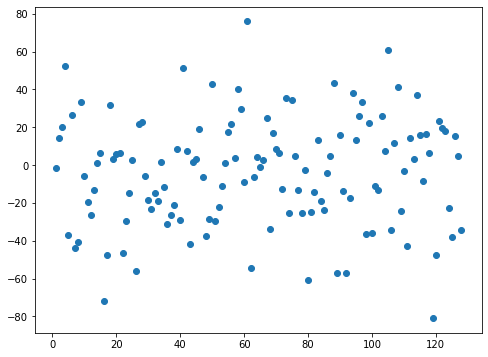

In [50]:
plt.scatter(x_axis1, Lv1_latent[0,2,:])

# Accuracy of VAE

In [51]:
temp4 = Lv1_latent[0,0,:]
temp4.shape

(128,)

In [52]:
temp4 = np.reshape(temp4, [-1, 128])
temp4.shape

(1, 128)

In [53]:
EX = Decoder(temp4) # EX : decoded temp4

In [54]:
print(Lv1_input.shape)

(2000, 14300, 4)


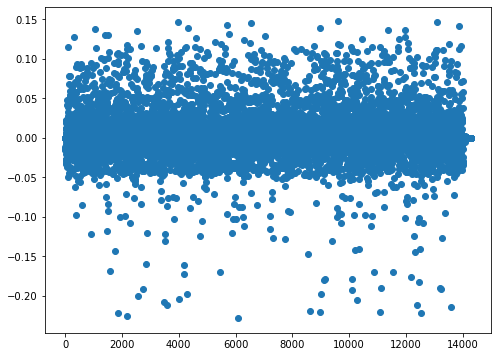

In [55]:
plt.scatter(x_axis, Lv1_input[0,:,0])

(1, 14300, 4)


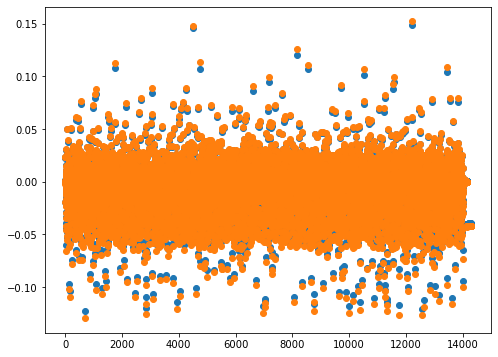

In [56]:
print(EX.shape)
plt.scatter(x_axis, EX[0,:,1])
plt.scatter(x_axis, Lv1_input[0,:,1])

In [57]:
Lv1_input.shape

(2000, 14300, 4)

# Reconstruction : time+parameter at a certain node point

In [58]:
Lv1_input.shape


(2000, 14300, 4)

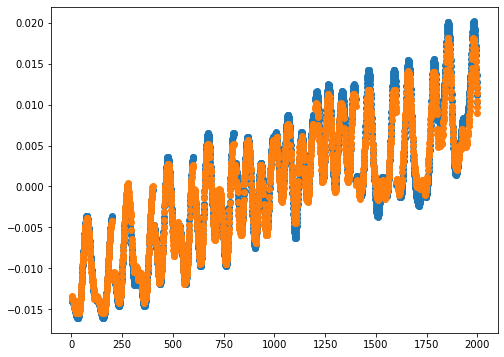

In [59]:
hola = np.zeros([1,14300,4])
hola4 = np.zeros([2000,14300,4])

for i in range(2000):
    hola[0,:,:] = Lv1_input[i,:,:]
    #print(hola.shape)
    hola2 = Encoder(hola)
    hola3 = Decoder(hola2)
    hola4[i,:,:]=hola3[0,:,:]

x_axis10 = np.linspace(1,2000,2000)
plt.scatter(x_axis10, Lv1_input[:,0,0])
plt.scatter(x_axis10, hola4[:,0,0])

In [60]:
hola = np.zeros([1,14300,4])

hola[0,:,:] = Lv1_input[0,:,:]
print(hola.shape)

(1, 14300, 4)


In [61]:

hola2 = Encoder(hola)
hola3 = Decoder(hola2)

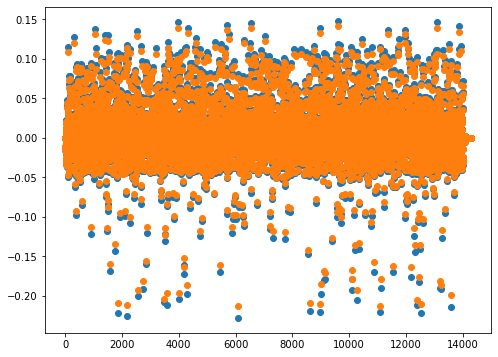

In [62]:
plt.scatter(x_axis, hola[0,:,0])
plt.scatter(x_axis, hola3[0,:,0])

(1, 14300, 4)


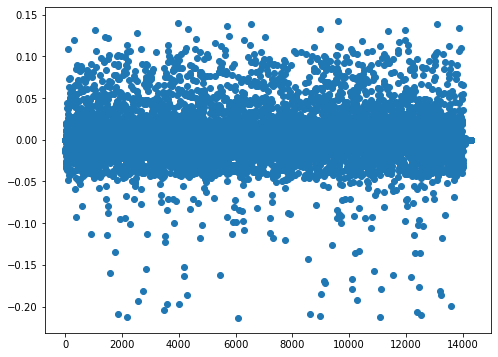

In [63]:
print(hola3.shape)
plt.scatter(x_axis, hola3[0,:,0])

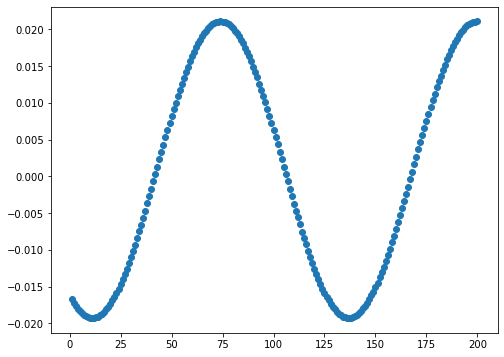

In [64]:
# FOM_data = (num_param, num_time, num_node, num_var)

x_axis1 = np.linspace(1,200,200)
plt.scatter(x_axis1, FOM_data[5,:,0,3])

# Output latent vectors to file,

In [65]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

In [66]:
Lv1_latent.shape

(10, 200, 128)

In [67]:
x_axis1 = np.linspace(1,128,128)

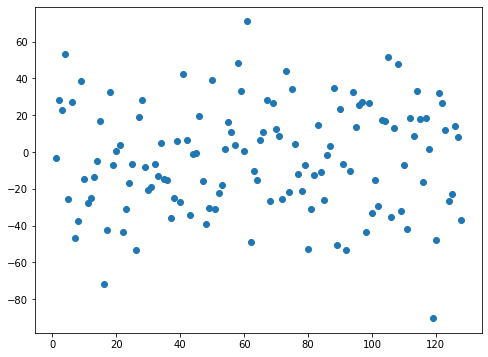

In [68]:
plt.scatter(x_axis1, Lv1_latent[0,0,:])

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [69]:
pause;

NameError: name 'pause' is not defined